In [55]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision
from matplotlib import pyplot as plt



# 1. Build and train a network to recognize digits


## A. Get the MNIST digit data set
The MNIST digit data consists of a training set of 60k 28x28 labeled digits and a test set of 10k 28x28 labeled digits. The data set can be imported directly from the torchvision package as torchvision.datasets.MNIST. Use the matplotlib pyplot package or OpenCV to look at the first six example digits. Look up examples that make use of the pyplot subplot method to create a grid of plots.

Include a plot of the first six example digits in your report.


In [56]:


def loadData(is_train):
    if(is_train):
        batch_num = 64
    else:
        batch_num = 1000
    
     # 1. transform the training input data to tensor and normalize it
    transform=torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize(
                    #   normalize with mean and std
                    (0.1307,), (0.3801,)
                )
                ])
    
    
    # 2. create a data loader
    data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            'mnist',
            train=is_train,
            download=True,
            transform=transform),
        batch_size=batch_num,
        shuffle=False)


    
    # Enumerate on test loader will give me batch index 
    # the train loader itself returning the images(example_data) and the label for it (example_target)
    return data_loader



    

In [57]:
def plotData(data_loader) :
    figure = plt.figure(figsize=(8, 8))
    
    # get the X and y
    examples = enumerate(data_loader)
    batch_idx, (sample_data, sample_targets) = next(examples)
    print("examining train_data")
    
    # print
    print(batch_idx)
    print(sample_data.shape)
    print(sample_targets.shape)
    
    # plot the first 6 sample
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.imshow(sample_data[i][0], cmap="gray", interpolation="none")
        plt.title("Ground truth: %d" %(sample_targets[i]))
        plt.xticks([])
                  
    plt.show()

## C. Build a network model
Similar to the example in the tutorial, create a network with the following layers.

CNN
- A convolution layer with 10 5x5 filters
- A max pooling layer with a 2x2 window and a ReLU function applied.

- A convolution layer with 20 5x5 filters
- A dropout layer with a 0.5 dropout rate (50%)
- A max pooling layer with a 2x2 window and a ReLU function applied

RNN
- A flattening operation followed by a fully connected Linear layer with 50 nodes and a ReLU function on the output
- A final fully connected Linear layer with 10 nodes and the log_softmax function applied to the output.


The design of your network class will be in the constructorand forward method of your Network class, derived from the torch nn.Module class.

Put a diagram of your network in your report.

In [58]:
# set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self):
        
        # call the parent constructor
        super(NeuralNetwork, self).__init__()
        
        #1. CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) 
        
        # final output : 20 Channels X 4 X 4
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # default is 0.5 or half
        
        #2. ANN
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(50, 10)
        
        self.flatten = nn.Flatten()
     

    def forward(self, x):
        # 1. first conv, max pool, relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # 2. 2nd conv, droptout layer, max pool, relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # 3. reshape tensor . why to -1, 320? this is same as flatten ?
        x = x.view(-1, 320)
        
        # 4. fully connected, relu
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Using cpu device


## D. Train the network

Train the model for five epochs, one epoch at a time, 
evaluating the model on both the training and test sets after each epoch. 

One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. 

Since one epoch is too big to feed to the computer at once we divide it in several smaller batches.

Pick a batch size of your choice. 
Make a plot

In [64]:
def train_network(network, train_loader, epoch_num):
    # 1. train mode
    network.train()
    
    # result to be plot
    train_losses = []
    train_counter = []
    
    # For each batch
    for batch_idx, (data, target) in enumerate(train_loader):
        # 2. Manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients.
        # use gradient descent
        learning_rate = 0.1
        momentum = 0.5
        optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                              momentum=momentum)

        optimizer.zero_grad()
        output = network(data)

        # 3. compute a negative log-likelihodd (nll) loss between the output and the ground truth label
        loss = F.nll_loss(output, target)
        loss.backward()

        # 4. The backward() call we now collect a new set of gradients
        # which we propagate back into each of the network's parameters using optimizer.step()
        optimizer.step()

        # 5. what is log_interval?
        print_interval = 10
        if batch_idx % print_interval == 0:
            # - print
            print('Train Epoch: {}, batch index:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num,
                batch_idx,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            # - append result to plot
            train_losses.append(loss.item()) # error value
            train_counter.append( # number of samples the model has seen
                (batch_idx*64) + ((epoch_num-1) * len(train_loader.dataset))
            )

            # - save network and optimizer
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')
            
    # return the error value for each batch and the number of samples
    return train_counter, train_losses
            

In [ ]:
def test(network, test_loader):
      network.eval()

## B. Make your network code reproducible
In order to make your code reproducible, set the random seed for the torch package, torch.manual_seed(42), at the start of your main function. Remove this line if you want to create different networks. You can use any number you like, it doesn't have to be 42. To make your processing truly repeatable, you will also need to turn off CUDA using torch.backends.cudnn.enabled = False

In [65]:
def main(argv):
    # 1. make network reproducible
    torch.manual_seed(42)
    torch.backends.cudnn.enabled = False
    
    # 2. load and plot data
    train_loader = loadData(is_train=True)
    plotData(train_loader)
    
    # 3. create network model
    network = NeuralNetwork()
    
    # 4. train network model
    epoch_num = 5
    
    # create list to plot the number of training samples on x axis, and the scores
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(epoch_num + 1)]
    
    for epoch in range(1, epoch_num + 1):
        train_counter, train_losses = train_network(network, train_loader, epoch)
        test_counter, test_losses = test_network(network, test_loader)
    

examining train_data
0
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 576x576 with 0 Axes>

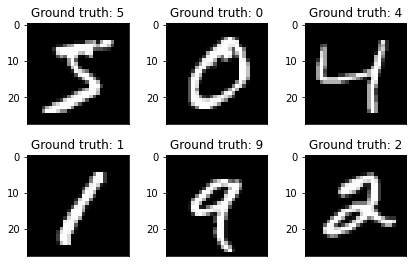

Train Epoch: 1, batch index:0 [0/60000 (0%)]	Loss: 2.310084


/var/folders/76/26vt73dx7psbzwyygdm5wtt40000gn/T/ipykernel_8910/207760786.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1, batch index:10 [640/60000 (1%)]	Loss: 2.268983
Train Epoch: 1, batch index:20 [1280/60000 (2%)]	Loss: 2.213526
Train Epoch: 1, batch index:30 [1920/60000 (3%)]	Loss: 2.040806
Train Epoch: 1, batch index:40 [2560/60000 (4%)]	Loss: 1.538668
Train Epoch: 1, batch index:50 [3200/60000 (5%)]	Loss: 1.321530
Train Epoch: 1, batch index:60 [3840/60000 (6%)]	Loss: 1.038834
Train Epoch: 1, batch index:70 [4480/60000 (7%)]	Loss: 0.749378
Train Epoch: 1, batch index:80 [5120/60000 (9%)]	Loss: 1.210124
Train Epoch: 1, batch index:90 [5760/60000 (10%)]	Loss: 0.839677
Train Epoch: 1, batch index:100 [6400/60000 (11%)]	Loss: 0.837987
Train Epoch: 1, batch index:110 [7040/60000 (12%)]	Loss: 0.605440
Train Epoch: 1, batch index:120 [7680/60000 (13%)]	Loss: 0.759476
Train Epoch: 1, batch index:130 [8320/60000 (14%)]	Loss: 0.638498
Train Epoch: 1, batch index:140 [8960/60000 (15%)]	Loss: 0.556563
Train Epoch: 1, batch index:150 [9600/60000 (16%)]	Loss: 0.510298
Train Epoch: 1, batch index:

In [66]:
main(sys.argv)